In [1]:
import os

os.chdir('/opt/ml/P-Stage/1-STAGE/')

from PIL import Image

import wandb
import torch
import pandas as pd
import torch.nn as nn

import matplotlib.pyplot as plt
from sklearn.metrics import (
    f1_score,
    recall_score,
    accuracy_score,
    precision_score,
    confusion_matrix,

)

from config import get_args
from prepare import get_dataloader, get_transforms, get_classes
from metrics import (
    FocalLoss,
    change_2d_to_1d,
    calulate_18class,
    tensor_to_numpy,
    tensor_images_to_numpy_images,
)

from log_helper import log_f1_and_acc_scores, log_confusion_matrix, log_confusion_matrix_by_images


def get_lossfn(args):
    # loss_fn = nn.CrossEntropyLoss()
    loss_fn = FocalLoss(gamma=2).to(args.device)
    return loss_fn

def get_all_datas(args, model, dataloader, get_image=True, argmax=True):
    model.eval()

    all_images = torch.tensor([]).to(args.device)
    all_labels = torch.tensor([]).to(args.device)
    all_preds = torch.tensor([]).to(args.device)

    with torch.no_grad():
        for idx, (images, labels) in enumerate(dataloader):
            images, labels = images.to(args.device), labels.to(args.device)

            preds = model(images)
            if argmax:
                preds = torch.argmax(preds, dim=1)
                preds = change_2d_to_1d(preds)
            if get_image:
                all_images = torch.cat((all_images, images))
            all_labels = torch.cat((all_labels, labels))
            all_preds = torch.cat((all_preds, preds))

    return all_images, all_labels, all_preds


def predict_and_logs_by_class_with_all_models(args, keys, models):
    """ loss_fn: use same model """

    final_zip_labels, final_zip_preds = [], []
    loss_fn = get_lossfn(args).to(args.device)

    summary_tables = pd.DataFrame([])
    cf_images = []

    for model, key in zip(models, keys):
        # mask, age, gender
        args.train_key = key
        _, valid_dataloader = get_dataloader(args)

        all_images, all_labels, all_preds = get_all_datas(args, model, valid_dataloader)

        #  all_images = tensor_images_to_numpy_images(all_images)
        all_labels = tensor_to_numpy(all_labels)
        all_preds = tensor_to_numpy(all_preds)

        summary_table = log_f1_and_acc_scores(args, all_labels, all_preds)
        summary_tables = summary_tables.append(summary_table)

        fig1 = log_confusion_matrix(args, all_labels, all_preds)
        # model for gradcam
        fig2 = log_confusion_matrix_by_images(args, model, all_images, all_labels, all_preds)

        cf_images.append(wandb.Image(fig1))
        cf_images.append(wandb.Image(fig2))
        
        print("cf_images:", cf_images)
        wandb.log({f"{key} Confusion Matrix": cf_images })

        final_zip_labels.append(all_labels)
        final_zip_preds.append(all_preds)

        cf_images = []

    summary_tables.fillna(0, inplace=True)
    summary_tables = summary_tables.applymap(lambda x: "{:,.1f}%".format(x*100))

    return summary_tables, final_zip_labels, final_zip_preds


def load_models(args):
    try:
        age_model = torch.load(args.age_model).to(args.device)
        gender_model = torch.load(args.gender_model).to(args.device)
        mask_model = torch.load(args.mask_model).to(args.device)

        age_model.eval()
        gender_model.eval()
        mask_model.eval()
    except Exception as e:
        raise e

    return [mask_model, gender_model, age_model]  # 순서 중요


def main(args):
    wandb.init(project="p-stage-1", reinit=True)
    wandb.config.update(args)
    wandb.run.name = f"predict-{wandb.run.name}"

    print(
        "".join([f"{k:<15} : {v}\n" for k, v in sorted(wandb.config.items(), key=len)])
    )

    models = load_models(args)
    keys = ["mask", "gender", "age"]

    # mga: mask, gender, age (sequence)
    summary_tables, mga_label_lists, mga_output_lists = predict_and_logs_by_class_with_all_models(
        args, keys, models
    )

    labels, preds = [], []

    for (mi, gi, ai) in zip(*mga_label_lists):
        labels.append(calulate_18class(mi, gi, ai))

    for (mi, gi, ai) in zip(*mga_output_lists):
        preds.append(calulate_18class(mi, gi, ai))

    ac_sco = accuracy_score(labels, preds)
    f1_sco = f1_score(labels, preds, average="macro")
    re_sco = recall_score(labels, preds, average="macro")
    pr_sco = precision_score(labels, preds, average="macro")

    table = wandb.Table(data=summary_tables.to_numpy(), rows=keys, columns=list(summary_tables))

    wandb.log({
        "predict_suumary_table(mask, gender, age)": table, 
        "total_valid_accuracy": ac_sco,
        "total_valid_f1_score": f1_sco,
        "total_valid_pr_score": pr_sco,
        "total_valid_re_score": re_sco
        })

In [3]:
args = get_args()
args.device = "cuda:0" if torch.cuda.is_available() else "cpu"

models = load_models(args)
keys = ['mask', 'gender', 'age']

args.test = False
args.train_key = "mask"

_, dataloader = get_dataloader(args)

In [17]:
images, labels = next(iter(dataloader))
images, labels = images.to(args.device), labels.to(args.device)

In [18]:
images.shape, labels.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [19]:
preds = models[0](images)

In [25]:
preds, labels = preds.detach().cpu().numpy(), labels.detach().cpu().numpy()

In [26]:
preds, labels

(array([[ 2.0238953 ,  0.7825736 , -3.3459544 ],
        [-0.4166462 , -0.8648597 ,  0.7973489 ],
        [ 2.440179  , -0.9016821 , -2.135751  ],
        [ 1.489993  ,  0.4481557 , -2.3935106 ],
        [-0.44544092, -0.3931895 ,  0.42671025],
        [ 1.3627998 ,  1.0154812 , -2.819764  ],
        [ 2.7166758 , -1.2961473 , -2.0784535 ],
        [ 3.0620372 , -2.4313626 , -1.4962453 ],
        [ 0.25222605, -0.89138   ,  0.19517237],
        [ 2.8600836 , -2.048237  , -1.5942814 ],
        [ 1.4686671 , -0.42661947, -1.513471  ],
        [ 0.24337456, -0.44961065, -0.17910928],
        [ 2.09161   , -0.3385707 , -2.2714071 ],
        [ 2.300428  , -1.0564231 , -1.8332713 ],
        [ 1.6158311 , -1.2266415 , -0.95674807],
        [-0.5896504 , -1.2635953 ,  1.327046  ],
        [ 1.7365493 , -1.4945219 , -0.8601102 ],
        [ 0.36609027,  0.13336228, -0.94636446],
        [-0.5149692 ,  0.36147767, -0.24629259],
        [ 2.2422817 , -1.4421103 , -1.4439975 ],
        [ 1.1416079 

In [27]:
from sklearn.metrics import precision_recall_curve

In [48]:
thresholds

array([0.36609027, 0.38871816, 0.49073735, 0.782665  , 0.8651606 ,
       0.8767735 , 0.8865626 , 0.94463694, 1.0228128 , 1.0448109 ,
       1.0606631 , 1.1416079 , 1.3627998 , 1.4686671 , 1.489993  ,
       1.5557271 , 1.5738267 , 1.5759442 , 1.6034583 , 1.6156167 ,
       1.6158311 , 1.7206589 , 1.7365493 , 1.8004769 , 1.8269007 ,
       1.915662  , 1.990992  , 2.0238953 , 2.0634696 , 2.09161   ,
       2.1132305 , 2.1533065 , 2.1997695 , 2.2293406 , 2.2422817 ,
       2.300428  , 2.3413548 , 2.3469315 , 2.387256  , 2.426461  ,
       2.429637  , 2.440179  , 2.546708  , 2.5536397 , 2.563874  ,
       2.6933875 , 2.7166758 , 2.8600836 , 2.934176  , 3.0620372 ,
       3.11476   ], dtype=float32)

In [46]:
preds[:, 0][:10]

array([ 2.0238953 , -0.4166462 ,  2.440179  ,  1.489993  , -0.44544092,
        1.3627998 ,  2.7166758 ,  3.0620372 ,  0.25222605,  2.8600836 ],
      dtype=float32)

In [44]:
labels

array([0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 2,
       0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 2,
       0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0])

In [31]:
labels == class_idx

array([ True, False,  True,  True, False,  True,  True,  True, False,
        True,  True, False,  True,  True,  True, False,  True,  True,
       False,  True,  True, False,  True,  True, False,  True,  True,
        True,  True, False,  True,  True, False,  True,  True,  True,
       False,  True,  True, False,  True,  True,  True, False,  True,
        True, False,  True,  True,  True, False,  True,  True, False,
        True,  True,  True, False,  True,  True, False,  True,  True,
        True])

In [93]:
class_idx = 1

precisions, recalls, thresholds = precision_recall_curve(labels == class_idx, preds[:, class_idx])

In [91]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    # plt.axis([-3, 3, 0, 1])             # Not show

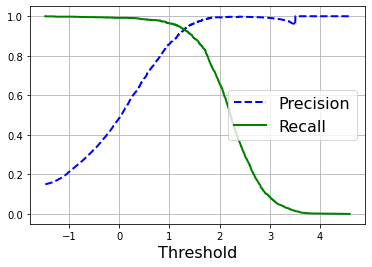

In [94]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [89]:
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support
class_thres = dict()

for class_idx in [0, 1, 2]:
    precisions, recalls, thresholds = precision_recall_curve(labels == class_idx, preds[:, class_idx])
    f1scores = 2 * (precisions * recalls) / (precisions + recalls)
    thres = thresholds[np.argmax(f1scores)]
    class_thres[class_idx] = thres
class_thres

{0: 0.73135847, 1: 1.3547943, 2: 0.7880771}

In [79]:
f1scores = 2 * (precisions * recalls) / (precisions + recalls)

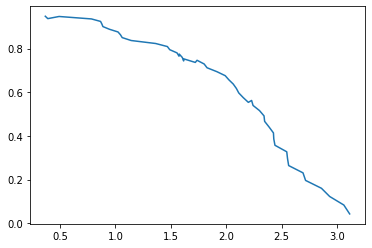

In [80]:
plt.plot(thresholds, f1scores[:-1])
plt.show()

In [81]:
class_idx = 0

In [4]:
import numpy as np

In [83]:
thres = thresholds[np.argmax(f1scores)]
thres

0.36609027

In [84]:
labels

array([0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 2,
       0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 2,
       0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0])

In [85]:
preds[:, 0] > thres

array([ True, False,  True,  True, False,  True,  True,  True, False,
        True,  True, False,  True,  True,  True, False,  True, False,
       False,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True, False,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True, False,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True])

In [86]:
fancy_idx = np.where(labels == class_idx)

In [87]:
temp_labels = preds[:, 0] > thres

In [92]:
temp_labels = temp_labels != True

In [89]:
fancy_idx

(array([ 0,  2,  3,  5,  6,  7,  9, 10, 12, 13, 14, 16, 17, 19, 20, 22, 23,
        25, 26, 27, 28, 30, 31, 33, 34, 35, 37, 38, 40, 41, 42, 44, 45, 47,
        48, 49, 51, 52, 54, 55, 56, 58, 59, 61, 62, 63]),)

In [93]:
temp_labels[fancy_idx] == labels[fancy_idx]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

# Original Score

In [49]:
images, labels, preds = get_all_datas(args, models[0], dataloader, get_image = False, argmax=False)

In [50]:
labels, preds = tensor_to_numpy(labels), tensor_to_numpy(preds)
len(preds)

9450

In [7]:
from predict import log_f1_and_acc_scores

In [8]:
args.train_key

'mask'

In [32]:
log_f1_and_acc_scores(args, labels, np.argmax(preds, axis=1))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0 f1,0 pr,0 re,0 acc,1 f1,1 pr,1 re,1 acc,2 f1,2 pr,2 re,2 acc
mask,0.332641,0.333333,0.331951,0.995852,0.324721,0.333333,0.316543,0.94963,0.332963,0.333333,0.332593,0.997778


In [10]:
preds

array([[ 2.0470128 ,  1.2380224 , -3.3770578 ],
       [-2.6095326 , -1.1919639 ,  2.963771  ],
       [ 2.3047693 , -0.1404494 , -2.475694  ],
       ...,
       [-0.4275375 ,  1.588988  , -1.2678562 ],
       [ 1.6881462 , -0.8642797 , -1.2331277 ],
       [ 2.0608785 ,  0.42043477, -2.696843  ]], dtype=float32)

In [86]:
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support
class_thres = dict()

for class_idx in [0, 1, 2]:
    precisions, recalls, thresholds = precision_recall_curve(labels == class_idx, preds[:, class_idx])
    f1scores = 2 * (precisions * recalls) / (precisions + recalls)

    thres = thresholds[np.argmax(f1scores)]
    class_thres[class_idx] = thres

In [87]:
class_thres

{0: 0.73135847, 1: 1.3547943, 2: 0.7880771}

In [19]:
np.argmax([1, 0])

0

In [63]:
images, labels, preds = get_all_datas(args, models[0], dataloader, get_image = False, argmax=False)
labels, preds = tensor_to_numpy(labels), tensor_to_numpy(preds)
len(preds)

9450

In [ ]:
for pred, arg_idx in zip(preds, np.argmax(preds, axis=1)):
    if pred[arg_idx] < class_thres[arg_idx]:
        pred[arg_idx] = 0
        outs.append()

In [105]:
pred - ct

array([ 1.32952  , -0.9343595, -3.48492  ], dtype=float32)

In [102]:
ct = np.array([cv for cv in class_thres.values()])
ct

array([0.73135847, 1.3547943 , 0.7880771 ], dtype=float32)

In [107]:
outs = []

for pred, label in zip(preds.copy(), labels):
    arg_index = np.argmax(pred)
    new_arg_index = np.argmax(pred - ct)
    new_arg_idx = arg_index
    if pred[arg_index] >= class_thres[arg_index]:
        outs.append(arg_index)
    else:
#         print(pred)
        pred[arg_index] = -5
        new_arg_idx = np.argmax(pred)
        outs.append(new_arg_idx)
#     if new_arg_idx != arg_index:
#         print(f"o: {arg_index} c: {new_arg_idx} {new_arg_idx == label}")

In [108]:
preds

array([[ 2.0470128 ,  1.2380224 , -3.3770578 ],
       [-2.6095326 , -1.1919639 ,  2.963771  ],
       [ 2.3047693 , -0.1404494 , -2.475694  ],
       ...,
       [-0.4275375 ,  1.588988  , -1.2678562 ],
       [ 1.6881462 , -0.8642797 , -1.2331277 ],
       [ 2.0608785 ,  0.42043477, -2.696843  ]], dtype=float32)

In [66]:
org_pred = np.argmax(preds, axis=1)

In [67]:
(np.array(outs) != org_pred).sum()

99

In [54]:
len(preds)

9450

In [55]:
len(outs)

9450

In [68]:
log_f1_and_acc_scores(args, labels, np.array(outs))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0 f1,0 pr,0 re,0 acc,1 f1,1 pr,1 re,1 acc,2 f1,2 pr,2 re,2 acc
mask,0.332641,0.333333,0.331951,0.995852,0.319444,0.333333,0.306667,0.92,0.332591,0.333333,0.331852,0.995556


In [69]:
log_f1_and_acc_scores(args, labels, np.argmax(preds, axis=1))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0 f1,0 pr,0 re,0 acc,1 f1,1 pr,1 re,1 acc,2 f1,2 pr,2 re,2 acc
mask,0.332467,0.333333,0.331605,0.994815,0.327684,0.333333,0.322222,0.966667,0.332963,0.333333,0.332593,0.997778
